In [1]:
import numpy as np #a. Numpy as np
import pandas as pd #b. Pandas as pd
import matplotlib.pyplot as plt #c. Matplotlib.pyplot
import seaborn as sns #d. seaborne as sns
%matplotlib inline
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

np.random.seed(0) #f. Configurar o random seed para 0 (np.random.seed(0))

#Importar os arquivos “kaggle/input/titanic/test.csv” e “kaggle/input/titanic/train.csv”
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

train_data.drop(['Cabin','Ticket'], axis=1, inplace=True)
test_data.drop(['Cabin','Ticket'], axis=1, inplace=True)

# Pipelines

**1. Deverá ser criada uma função que produz e avalia pipelines que utilizam diversas estratégias de imputing de valores nulos e encoding de variáveis categóricas.**

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


X = train_data.copy()
X.drop(['PassengerId','Name'], axis=1, inplace=True) # not important for training, but must be used for submitting results
y = X.pop("Survived")

# Select categorical columns
def categorical_cols(X):
    return [cname for cname in X.columns if X[cname].dtype  == "object"]

# Select numerical columns
def numerical_cols(X):
    return [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_cols(X)),
    ('cat', categorical_transformer, categorical_cols(X))
])

# Define model
model = RandomForestClassifier()
#model = XGBClassifier(n_estimators=1000, random_state=0, n_iter_no_change = 100, verbose=False)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                     ])

scores = cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='accuracy')
print(scores.mean())

0.8081099742640134


# Feature Selection

In [3]:
#Get the transformed dataset
X_preprocessed = pd.DataFrame(preprocessor.fit_transform(X))
X_preprocessed.columns = numerical_cols(X)+list(my_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names())
X_preprocessed

,Pclass,Age,SibSp,Parch,Fare,x0_female,x0_male,x1_C,x1_Q,x1_S
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,1.0
887,1.0,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0
888,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0
889,1.0,26.0,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0


**1. O primeiro passo é a avaliação da importância de cada feature que já está no banco de dados de teste, para isso será criada uma função que produza um gráfico indicado o Mutual Information score de cada feature existente no banco de dados d treino, em relação ao target**

x0_female    0.149227
x0_male      0.138992
Fare         0.123840
Age          0.046738
Pclass       0.037417
SibSp        0.030693
x1_S         0.019123
Parch        0.000000
x1_C         0.000000
x1_Q         0.000000
Name: MI Scores, dtype: float64


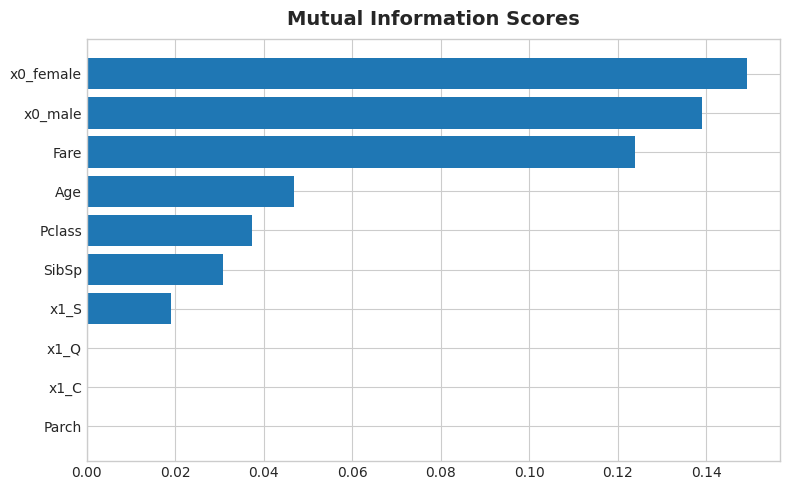

In [4]:
from sklearn.feature_selection import mutual_info_regression

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X_preprocessed, y)
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

**2. Após a observação do gráfico gerado é possível concluir que as features que as features com maior influência no target são “Fare”, “Sex” e “Age”, por este motivo, elas serão analisadas mais a fundo por meio da utilização de gráficos. Para facilitar a visualização dos dados, é útil que seja usado um banco de dados que ainda contenha as features categóricas originais**

<AxesSubplot:xlabel='Fare', ylabel='Count'>

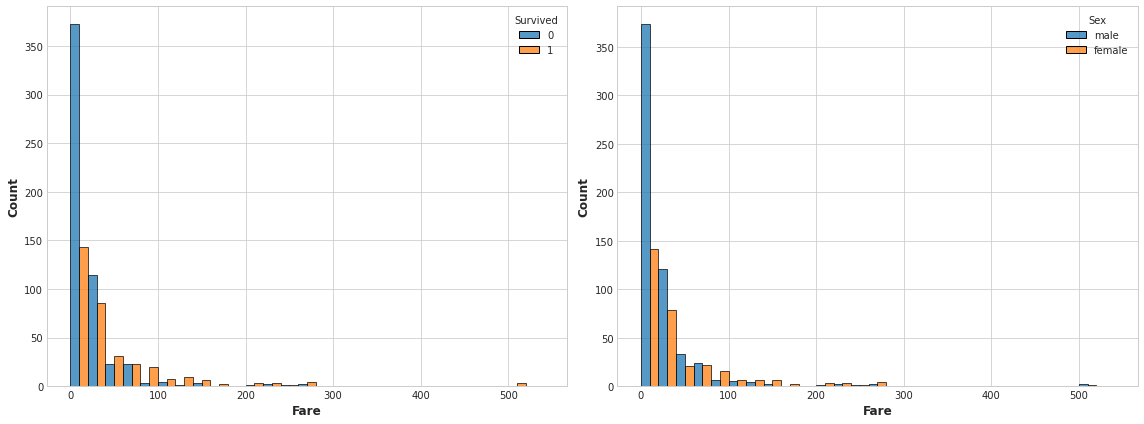

In [5]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sns.histplot(data=train_data, hue="Survived", bins=range(0, 550, 20), x="Fare",  multiple='dodge')

plt.subplot(122)
sns.histplot(data=train_data, hue="Sex", bins=range(0, 550, 20), x="Fare",  multiple='dodge')

<AxesSubplot:xlabel='Age', ylabel='Count'>

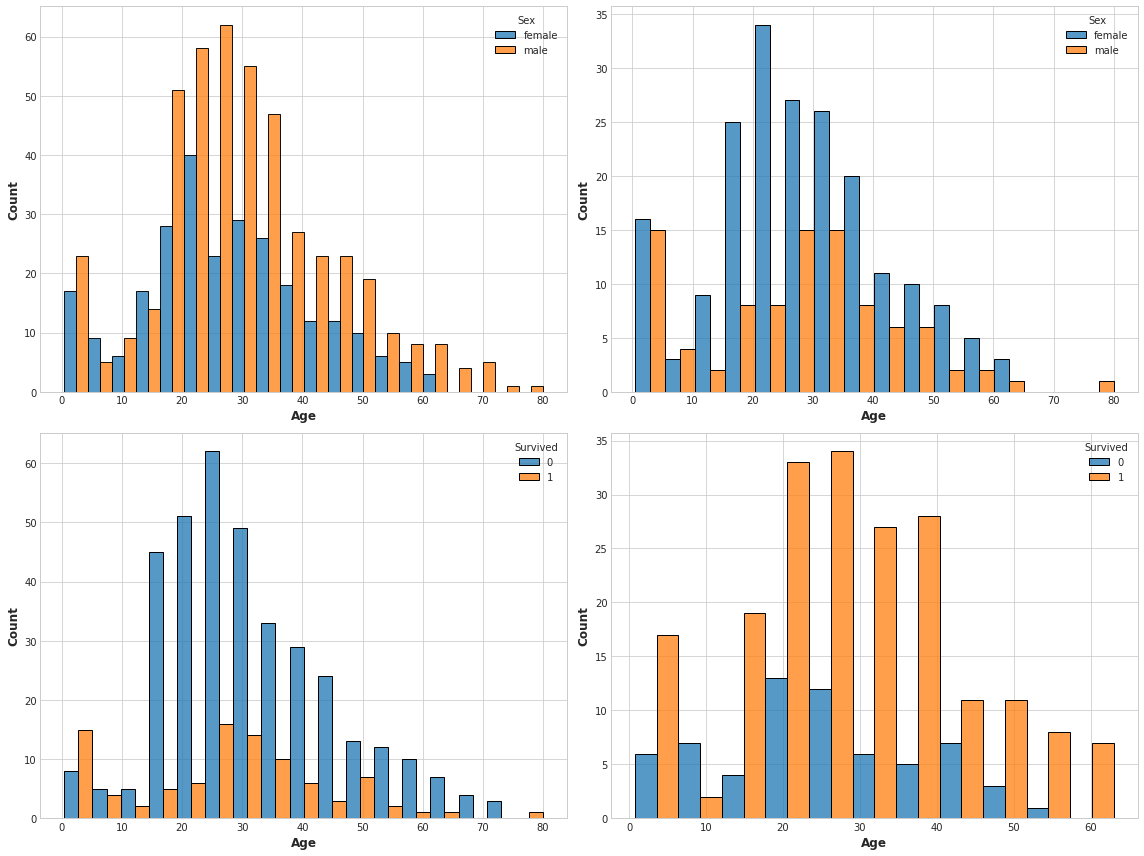

In [6]:
plt.figure(figsize=[16,12])

plt.subplot(221)
sns.histplot(data=train_data, hue="Sex", hue_order=["female", "male"], x="Age",  multiple='dodge') 

plt.subplot(222)
sns.histplot(data=train_data.loc[train_data['Survived']==1], hue="Sex", hue_order=["female", "male"], x="Age",  multiple='dodge')

plt.subplot(223)
sns.histplot(data=train_data.loc[train_data['Sex']=="male"], hue="Survived", x="Age",  multiple='dodge')

plt.subplot(224)
sns.histplot(data=train_data.loc[train_data['Sex']=="female"], hue="Survived", x="Age",  multiple='dodge')

# Feature Construction

**1. Na feature “Name” existe, para cada passageiro, um título, como “Mr” ou “Miss”. Esta informação pode ser útil, então podemos criar uma nova coluna para obter estes dados.**

In [7]:
#a. A partir de “Name” criar a feature “Title” para separar os valores, primeiramente, pela vírgula, e depois pelo ponto. Para isso deve-se utilizar o 
#   método str.split, lembre-se de criar uma nova coluna para armazenar estas informações, após isso, pode-se excluir a feature “Names”
X2 = train_data.copy()
X2.drop(['PassengerId','Name'], axis=1, inplace=True) # not important for training, but must be used for submitting results
y2 = X2.pop("Survived")

X2['Title'] = train_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0].copy()

**2. Criar novas Features para resumir informações de outras já existentes, uma para indicar o número total de familiares de cada passageiro, sejam eles primos, filhos ou acompanhantes, e outra para informar se o passageiro está sozinho ou não.**

In [8]:
#a. Criar feature que indique o tamanho da família, somando “SibSp” e “Parch”.
X2['FamilySize'] = X2['SibSp'] + X2['Parch'] + 1
    
#b. Criar feature booleana indicando se o passageiro está sozinho, sendo, verdadeiro caso não tenha nenhum familiar a bordo, e falso caso tenha.
X2['IsAlone'] = 1 #initialize to yes/1 is alone
X2['IsAlone'].loc[X2['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
X2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,3,male,35.0,0,0,8.0500,S,Mr,1,1
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,1,1
887,1,female,19.0,0,0,30.0000,S,Miss,1,1
888,3,female,NaN,1,2,23.4500,S,Miss,4,0
889,1,male,26.0,0,0,30.0000,C,Mr,1,1


# Feature Extraction

**1. No banco de dados em que estamos trabalhando existem duas features com valores contínuos, são "Fare'' e “Age”, portanto, a partir da interação entre elas pode-se criar grupos utilizando K-means como forma de clustering.**

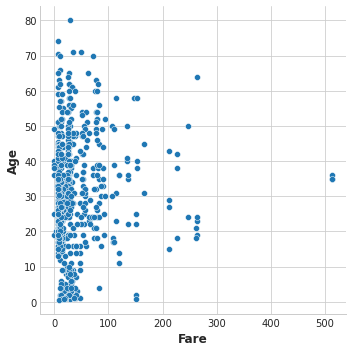

In [9]:
#a. O primeiro passo é analisar a distribuição dos passageiros levando em consideração “Fare” e “Age”
#  i. Produzir um gráfico, do tipo scatter plot, colocando “Age” e “Fare” como eixos.
#  ii. Nesta distribuição é possível identificar outliers, esses valores devem ser retirados para que o algoritmo k-means, encontre os grupos da maneira 
#      correta. Como esses valores podem ser retirados?
sns.relplot(x="Fare", y="Age", data=X2);

**b. Agora será necessário criar os grupos utilizando a biblioteca K-means do sklearn**

In [10]:
from sklearn.cluster import KMeans
#i. Crie um dataframe que contenha apenas as features “Age” e “Fare”, para remover os outliers, selecione apenas os passageiros que tenham as taxas menores 
#   que 500.
X3 = X_preprocessed[["Fare","Age"]].copy()
X3=X3[X3["Fare"]<500]
#ii. Crie um algoritmo k-means que produza 6 grupos.
kmeans = KMeans(n_clusters=6)

#iii. Utilizando este algoritmo, produza uma nova coluna no dataframe criado, contendo os grupos de cada passageiro
X3["Cluster"] = kmeans.fit_predict(X3)
X3


,Fare,Age,Cluster
0,7.2500,22.0,4
1,71.2833,38.0,5
2,7.9250,26.0,4
3,53.1000,35.0,5
4,8.0500,35.0,4
...,...,...,...
886,13.0000,27.0,4
887,30.0000,19.0,1
888,23.4500,28.0,1
889,30.0000,26.0,1


**c. Agora será útil entender quais as características de cada grupo criado pelo algoritmo, para isso serão utilizados dois gráficos, um para identificar os grupos na distribuição “Age” x “Fare”, outro para avaliá-los em relação à chance de sobrevivência.**

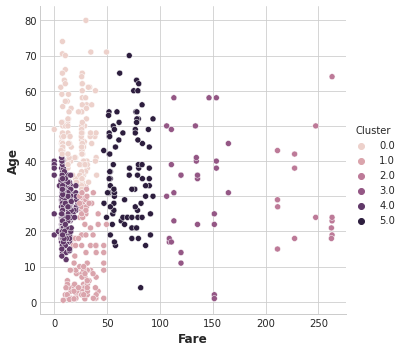

In [11]:
#i. Adicionar a nova feature ao banco de dados de treino. 
train_data["Cluster"] = X3["Cluster"].copy()
#ii. Construir um gráfico scatter plot que mostra a distribuição “Fare” x “Age”, tendo os grupos como camadas.
sns.relplot(x="Fare", y="Age", hue="Cluster", data=train_data);


<AxesSubplot:xlabel='Cluster', ylabel='Count'>

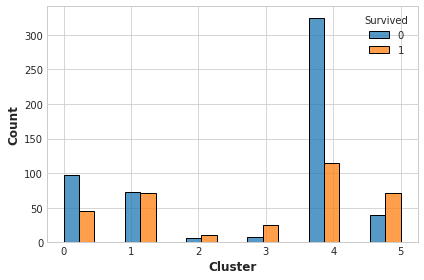

In [12]:
#iii. Um gráfico bar chart que indique a chance de sobrevivência, em média, de cada grupo.
sns.histplot(data=train_data, x="Cluster", hue="Survived", multiple='dodge')
#sns.barplot(x=X_preprocessed.Cluster, y=X_preprocessed["Survived"].astype(bool).sum(axis=0))
#iv. Faça uma análise qualitativa do que cada grupo representa e discuta sobre as chances de sobrevivência médias

**2. Ao analisarmos a nova feature, é fácil notar que existem valores nulos, estes valores correspondem aos outliers que foram retirados para a construção dos grupos. Para substituir os NaN, deve-se identificar quem são esses outliers e designar, manualmente, seu grupo**

In [13]:
train_data["Cluster"].isna().sum()

3

In [14]:
train_data["Cluster"] = train_data["Cluster"].fillna(2)

**3. Agora avalie, utilizando mutual information, se a nova feature é significativa para a previsão do target (Utilize os passos mostrados em 9.1 - 1)**

x0_female    0.150490
Fare         0.131156
x0_male      0.116506
SibSp        0.079257
Cluster      0.063524
x1_S         0.034743
Pclass       0.020989
Age          0.016673
Parch        0.010615
x1_C         0.000000
x1_Q         0.000000
Name: MI Scores, dtype: float64


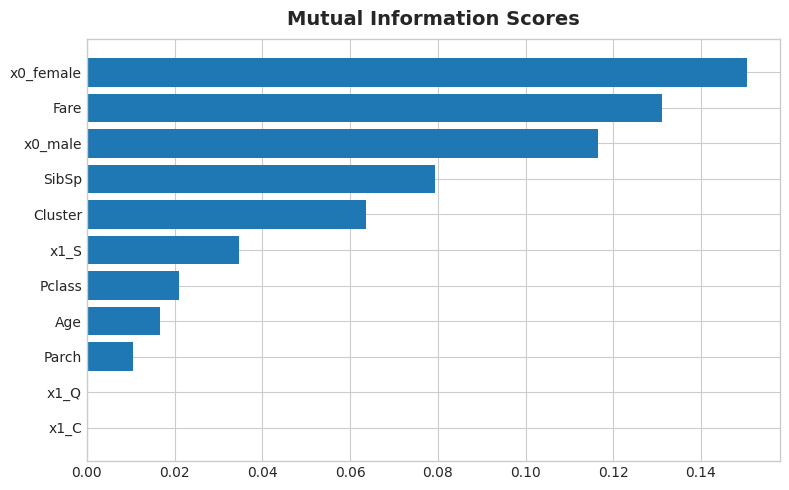

In [15]:
X_preprocessed["Cluster"] = train_data["Cluster"].copy()

mi_scores = make_mi_scores(X_preprocessed, y)
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

**4. As features originais não representam a mesma grandeza, “Age” conta a idade em anos e “Fare” a taxa de embarque em dólares, portanto, para que seja possível utilizar o PCA, deve-se primeiramente realizar os scaling das variáveis. para esta etapa será utilizado o MinMax Scaler do scikit learn**

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame()
columns = ["Age","Fare"]

X3[columns] = pd.DataFrame(scaler.fit_transform(X3[columns]))
   
X3.head()

,Fare,Age,Cluster
0,0.027567,0.271174,4
1,0.271039,0.472229,5
2,0.030133,0.321438,4
3,0.201901,0.434531,5
4,0.030608,0.434531,4


<AxesSubplot:xlabel='Fare', ylabel='Count'>

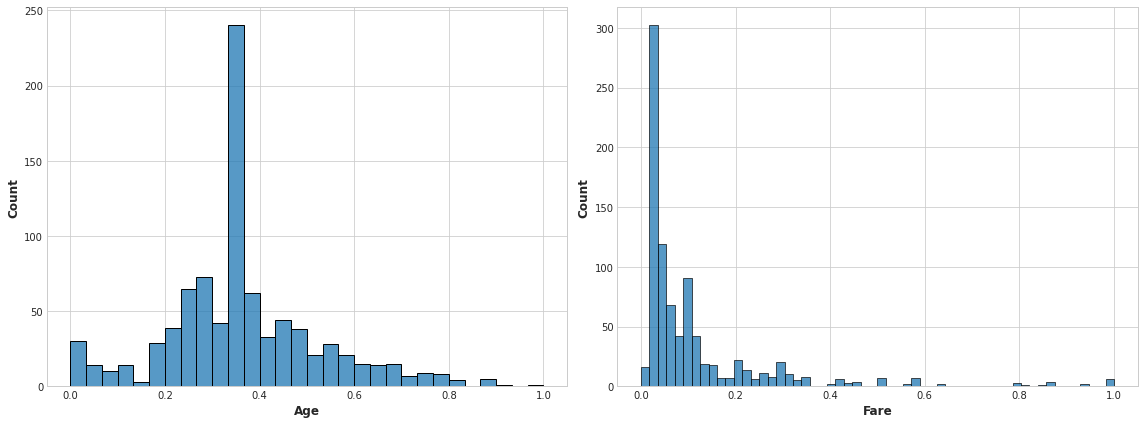

In [17]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sns.histplot(data=X3, x="Age")

plt.subplot(122)
sns.histplot(data=X3, x="Fare")

**5. Agora já é possível realizar o PCA, contudo, não há garantias que esta estratégia trará novas informações úteis para o modelo, portanto, é necessário, após a criação dos novos eixos, analisar criticamente se vale a pena introduzi-los ao banco de dados.**

In [18]:
from sklearn.decomposition import PCA

#pca = PCA()
#X_pca = pca.fit_transform(X3)